# INFO F422 - Statistical Fundation of Machine Learning
## Project "House Prices : Advanced Regression Techniques"

    Erica Berghman
    Master 1 - Brussels Engineer School

## Abstract

## 1. Introduction 

> with dataset description, goals, and an overview of the report structure 

> Starting from a data set with 81 criteria about houses and their selling price, the goal is to create a model capable of predicting the price of other houses given some of these criterias. A good model description is a model that has been refined multiple types. This report will show the methodology used to construct a model for this particular problem. It is based on the methodology of the Chapter 6 of the syllabus.

## 2. Preprocessing 

In [1]:
dataSample = 400
mean = T          # variable to determine if we use the mean or the median to replace the NA values
set.seed(1)

source("functions/replaceNA.R")
# Hide warnings
options(warn=-1)

In order to get a model, the data must be preprocessed. Firstly we read the data given and we take a sample set of 400 houses out of the 1460. There is 81 criteria.

In [2]:
data<-read.csv("input/train.csv")
data.sample<-data[sample(nrow(data),dataSample),]
#dim(data.sample)
#data[1:2,]

## 2.1 Categorical criteria

The categorical (factor) criterias are removed.

In [3]:
factor_variables<-which(sapply(data.sample[1,],class)=="factor")
data.sample.nofactor<-data.sample[,-factor_variables]
data.sample.factor<-data.sample[,factor_variables]
#summary(data.sample.factor)

Some of them are then added. (TODO justification)

In [4]:
library(dummies)
variable_to_keep<-c("CentralAir", "Street", "LotShape")
data_factor_onehot <- dummy.data.frame(data.sample.factor[,variable_to_keep], sep="_")
data.nofactor.extended<-cbind(data.sample.nofactor,data_factor_onehot)

dummies-1.5.6 provided by Decision Patterns



### 2.2 Missing data 
The missing values (NA) are replaced by an estimator of these values (eg. mean or median).

In [5]:
if (mean) {
    data_preprocessed<-data.frame(apply(data.nofactor.extended,2,replace_na_with_mean_value)) 
} else {
    data_preprocessed<-data.frame(apply(data.nofactor.extended,2,replace_na_with_median_value))
}

## 3. Feature selection 
> Methodology and main results

> The text must contain the list of selected variables and the motivation of their choice. The use of formulas, tables and pseudo-code to describe the feature selection procedure is encouraged. 

### 3.1 Redundant and irrelevant features 
The "Id" column which is irrelevant is deleted.

In [6]:
data_preprocessed<-data_preprocessed[,setdiff(colnames(data_preprocessed),"Id")]

The criterias that are redundant (linear combination of others criterias and correlation > 0.99) are deleted.

In [7]:
#library(caret)
library(ggplot2)
library(lattice)

#linearCombo.idx <- findLinearCombos(data_preprocessed)$remove
#if (!is.null(linearCombo.idx)) data_preprocessed<-data_preprocessed[,-linearCombo.idx]

correlation.matrix <- cor(data_preprocessed)
correlation.matrix[upper.tri(correlation.matrix)] <- 0
diag(correlation.matrix) <- 0
data.uncorrelated <- data_preprocessed[,!apply(correlation.matrix,2,function(x) any(abs(x) > 0.99))]
dim(data.uncorrelated)

[1] 400  43

The input and output vectors are created and scaled.

In [8]:
X <- data.uncorrelated[,setdiff(colnames(data.uncorrelated),"SalePrice")]
Y <- data.uncorrelated[,"SalePrice"]
X <- data.frame(X)
#Y <- data.frame(Y)
X.scale <- data.frame(scale(X))
Y.scale <- scale(Y)

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables

In [9]:
dim(X)
X.tr.mean <- colMeans(X)
X.tr.std <- apply(X,2,sd)

[1] 400  42

### 3.2 Filter methods

   It create a subset of features, removing from the whole features set the ones less likely to determine the variable (SalePrice). It is robust to overfitting and effective in computational time. However it might select redundant variables as the interraction between the variables is not taken in consideration.  

In [10]:
source("functions/filtre.R")
features.filtre <- filtre(X.scale,Y.scale)  # return the idx of the more correlated features where #feature = argmin(CV error)

In [11]:
X.filtre = X.scale[,features.filtre]
dim(X.filtre)
X.filtre[1:2,]

[1] 400  35

,OverallQual,GrLivArea,TotalBsmtSF,X1stFlrSF,GarageCars,GarageArea,FullBath,YearRemodAdd,TotRmsAbvGrd,YearBuilt,...,BsmtUnfSF,MSSubClass,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,X3SsnPorch,MiscVal,OverallCond,LotShape_IR2
388,-0.09423743,-0.7470902,-0.06201711,-0.108574,-0.9763774,-0.5683105,-1.0707010,-0.4480077,-0.3212315,0.1227521,...,-0.3683924,0.6140872,0.1035,-0.2291288,-0.3559642,-0.2798042,-0.117066,-0.1506729,0.3556585,-0.1599279
543,0.59112569,0.2952237,1.38021372,1.346596,0.2753885,0.4394986,0.7595571,0.6441150,0.2906380,0.8516444,...,-0.4352562,-0.8436866,0.1035,-0.2291288,-0.3559642,-0.2798042,-0.117066,-0.1506729,-0.4811850,-0.1599279


In [12]:
source("functions/mRMR.R")
features.mrmr <- mrmr(X.scale, Y.scale)    # return the idx of the more correlated features where #feature = argmin(CV error)

In [13]:
X.mrmr <- X.scale[,features.mrmr]
dim(X.mrmr)

[1] 400  40

In [14]:
source("functions/pca.R")
X.pca <- pca(X.scale, Y.scale)   # return X_pca with nb of columns = argmin(CV error)
dim(X.pca)

[1] 400  40

### 3.3 Wrapper method

Its a cyclic method where a subset of variable is created and evaluated by the Learning Algorithm, modifying the chosen subset. This is done until the best subset is generated.  

In [15]:
source("functions/wrapper.R")
features.wrapper <- wrapper(X.scale, Y.scale)

ERROR: Error in source("functions/wrapper.R"): functions/wrapper.R:45:5: unexpected symbol
44:     nb_features.best <- which.min(round(CV.err.mean[selected_current],digits=4)
45:     print
        ^


In [ ]:
X.wrapper <- X[,features.wrapper]
dim(X.wrapper)

### 3.4 Hybrid method
The filter method is used to select a first "big" set of features, that is then refined by the wrapper method. This gives us the possibility use advantages of both method to get a good subset in a relatively correct computational time.

In [ ]:
features.wrapper.pca <- wrapper(X.pca, Y.scale)


## 4. Model selection  
> Methodology and main results

> For the learning method, the only packages that may be used are those seen during the exercise classes : stats, nnet, tree, lazy, and e1071, for linear models, neural networks, decision trees, nearest neighbours and SVM, respectively.

> The accuracy of the regression models during the selection process should be assessed by using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sale price.

> The text must mention the different (and at least three) models which have been taken into consideration and the procedure used for model assessment and selection. The use of formulas, tables and pseudo-code to describe the feature selection procedure is encouraged

### 4.1 Linear Model

In [16]:
library(stats)

In [9]:
DS<-cbind(X.scale,SalePrice=Y.scale)
model.linear <- lm(SalePrice~.,DS) ### IMDB score given all the other ones (~.) over the dataset DS

Y.hat <- predict(model.linear, X.scale)

empirical_error<-mean((Y.hat-Y.scale)^2) ### MSE for prediction of that model.
print(paste("Empirical error=",round(empirical_error,digits=4)))

[1] "Empirical error= 0.0916"


In [54]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
    # 1/10 for testing
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]    
    
    #9/10 for training
     i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]         
     
    #scaling
     X.tr.mean <- colMeans(X.tr)
     X.tr.sd <- apply(X.tr,2,sd)
    Y.tr.mean <- mean(Y.tr)
    Y.tr.sd <- sd(Y.tr)

    Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
    X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    
    #scaling the testing test by the same scaling as of the training set
    X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 
    
    X.ts <-data.frame(X.ts)
    X.tr <-data.frame(X.tr)
        

    DS<-cbind(X.tr,SalePrice=Y.tr)
    
    model.linear<- lm(SalePrice~.,DS)      # create model with the training set
        
    Y.hat.ts<- predict(model.linear,X.ts)  # predict value for the test set
        
    CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)  # MSE for test set
}
    
print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))

[1] "CV error= 0.1744  ; std dev= 0.1945"


### 4.2 Decision tree

In [57]:
DS<-cbind(X.scale,SalePrice=Y.scale)
model.tree <- rpart(SalePrice~.,DS)
        
Y.hat <- predict(model.tree,X.scale)
        
empirical_error<-mean((Y.hat-Y.scale)^2) 
print(paste("Empirical error=",round(empirical_error,digits=4)))

[1] "Empirical error= 0.1923"


Cross validation

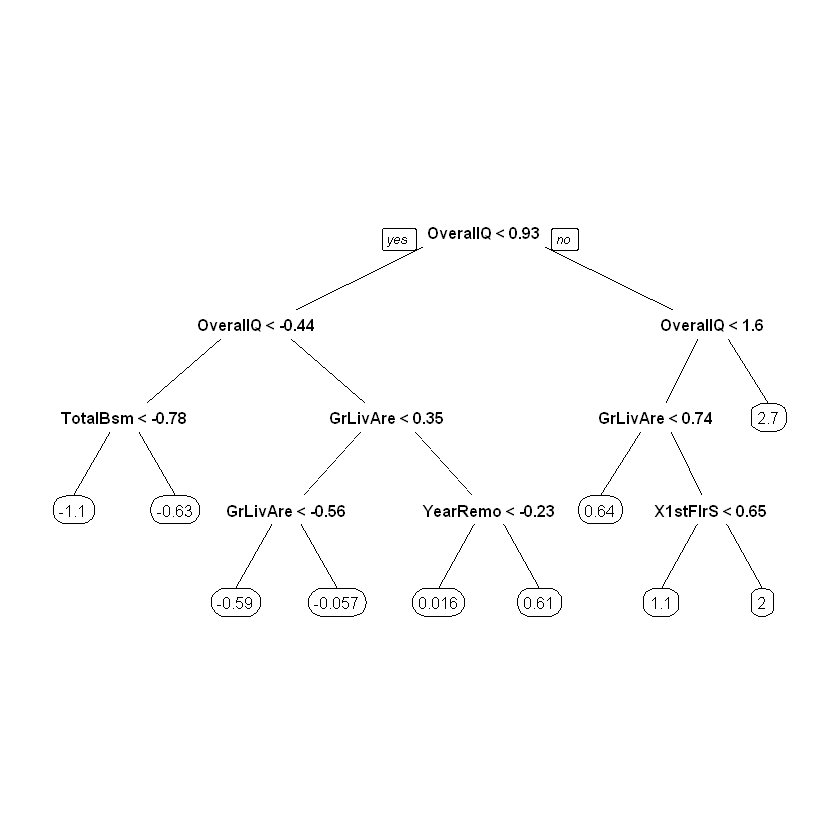

In [58]:
library(rpart.plot)
prp(model.tree)

In [59]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
    # 1/10 for testing
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]    
    
    #9/10 for training
     i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]         
     
    #scaling
     X.tr.mean <- colMeans(X.tr)
     X.tr.sd <- apply(X.tr,2,sd)
    Y.tr.mean <- mean(Y.tr)
    Y.tr.sd <- sd(Y.tr)

    Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
    X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    
    #scaling the testing test by the same scaling as of the training set
    X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 
    
    X.ts <-data.frame(X.ts)
    X.tr <-data.frame(X.tr)                       
     
     DS<-cbind(X.tr,SalePrice=Y.tr)
    
     model<- rpart(SalePrice~.,DS)
        
     Y.hat.ts<- predict(model.tree,X.ts)
        
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
    }
    

print(paste("CV error =",round(mean(CV.err),digits=4), " std dev =",round(sd(CV.err),digits=4)))


[1] "CV error = 0.2325  std dev = 0.2906"


In [33]:
?nnet

### 4.3 Neural network

In [10]:
library(nnet)

In [11]:
DS<-cbind(X.scale,SalePrice=Y.scale)
for (i in 5:22){
    #model.neural[i] <- nnet(SalePrice~.,DS, size = i, linout=T, maxit = 1000)
    Y.hat <- predict(nnet(SalePrice~.,DS, size = i, linout=T, maxit = 1000),X.scale)

    empirical_error[i] <- mean((Y.hat-Y.scale)^2) 
    print(paste("Number of neurones: ", i, "Empirical error = ",round(empirical_error[i],digits=4)))
}

# weights:  221
initial  value 482.169307 
iter  10 value 83.591382
iter  20 value 51.205708
iter  30 value 42.132795
iter  40 value 34.754309
iter  50 value 27.572751
iter  60 value 23.183973
iter  70 value 17.539671
iter  80 value 13.653254
iter  90 value 11.221008
iter 100 value 9.986719
iter 110 value 9.071293
iter 120 value 8.476875
iter 130 value 8.073844
iter 140 value 7.895714
iter 150 value 7.734080
iter 160 value 7.516339
iter 170 value 7.229372
iter 180 value 6.998418
iter 190 value 6.731336
iter 200 value 6.541693
iter 210 value 6.253488
iter 220 value 6.107651
iter 230 value 6.039122
iter 240 value 5.995854
iter 250 value 5.895951
iter 260 value 5.858728
iter 270 value 5.828831
iter 280 value 5.814106
iter 290 value 5.797464
iter 300 value 5.790562
iter 310 value 5.783974
iter 320 value 5.779930
iter 330 value 5.778029
iter 340 value 5.776181
iter 350 value 5.773637
iter 360 value 5.771632
iter 370 value 5.770405
iter 380 value 5.768526
iter 390 value 5.766889
iter 400 val

ERROR: Error in nnet.default(x, y, w, ...): too many (1013) weights


#### Parameter "size"
An analysis of the number of neurones is done. The maximum of neurones used is 20 as more return an error (too many weights).


In [29]:
#juste un save pour les tests
empirical_error <- c(0.0143671130358607, 0.015019445363705, 0.00821834907673351, 0.0054200745645435, 0.00142228029226354, 5.25161597874794e-05, 1.52899010549121e-06, 2.47317346679477e-07, 2.37597648006074e-07, 2.47841099771862e-07, 2.26350153783801e-07, 2.30675129791945e-07, 2.44205643742954e-07, 2.4713486169669e-07, 2.40667851762e-07, 2.31459671090645e-07, 2.39175596505192e-07, 2.24902711484879e-07) 

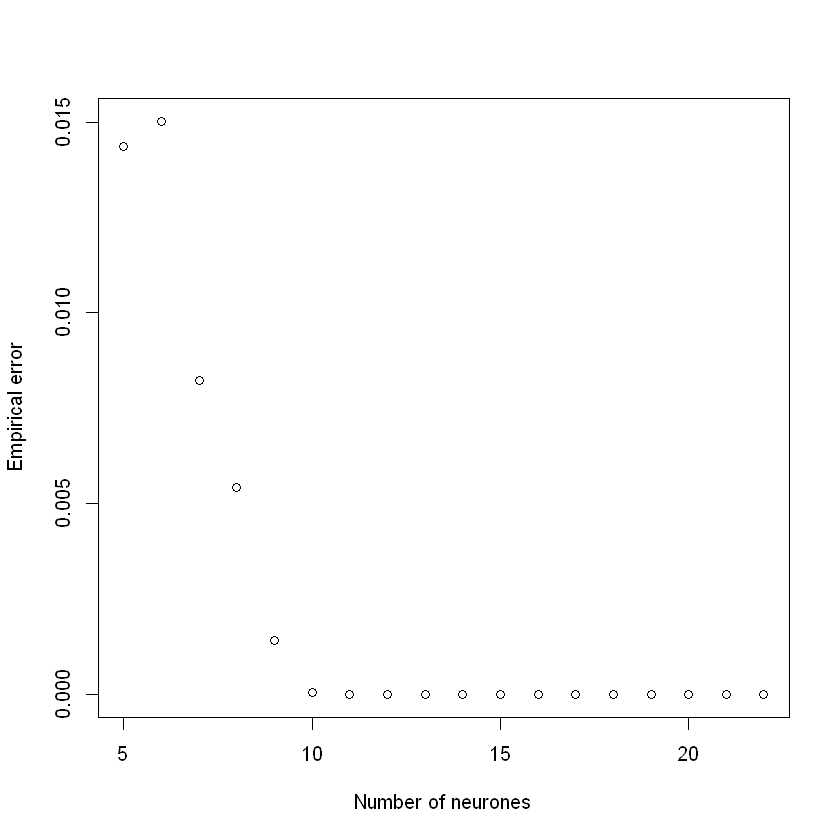

In [39]:
plot(c(5:22),empirical_error, xlab = "Number of neurones", ylab = "Empirical error")

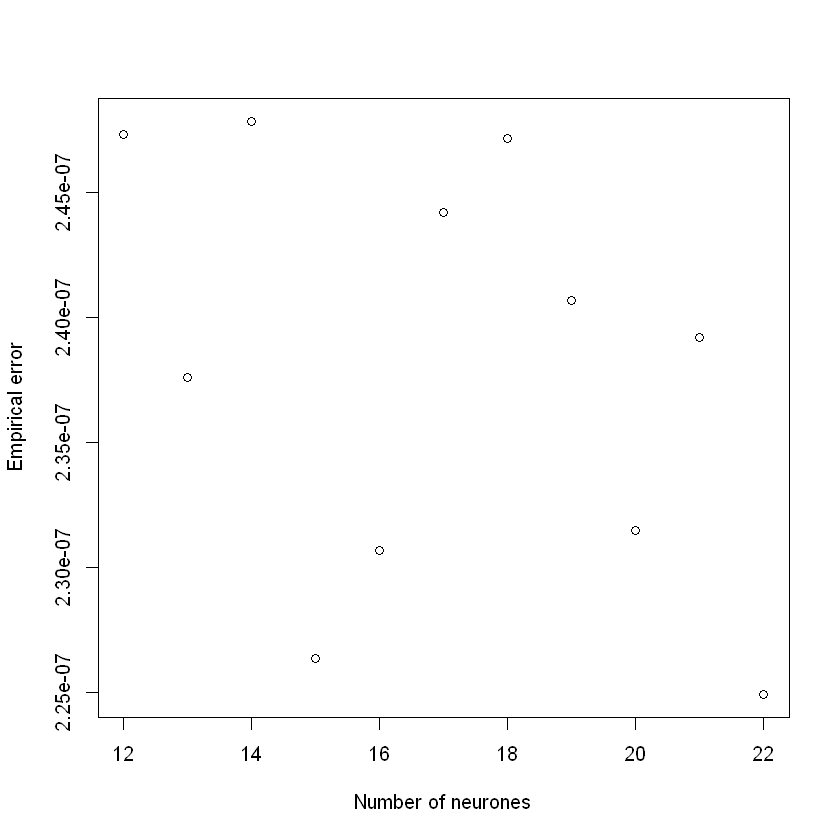

In [41]:
plot(c(12:22),empirical_error[8:18], xlab = "Number of neurones", ylab = "Empirical error")  # zoom

In [42]:
size.CV<-floor(N/10)

CV.err<-numeric(10)
mean.size<-numeric(13)

for (j in 10:22){
    
    for (i in 1:10) {
        # 1/10 for testing
         i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
         X.ts<-X[i.ts,]  
         Y.ts<-Y[i.ts]    

        #9/10 for training
         i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
         X.tr<-X[i.tr,]
         Y.tr<-Y[i.tr]         

        #scaling
         X.tr.mean <- colMeans(X.tr)
         X.tr.sd <- apply(X.tr,2,sd)
        Y.tr.mean <- mean(Y.tr)
        Y.tr.sd <- sd(Y.tr)

        Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
        X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))

        #scaling the testing test by the same scaling as of the training set
        X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
        Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 

        X.ts <-data.frame(X.ts)
        X.tr <-data.frame(X.tr)                       

         DS <- cbind(X.tr,SalePrice=Y.tr)
        
         model.neural <- nnet(SalePrice~.,DS, size = j, linout=T, maxit = 1000)

         Y.hat.ts<- predict(model.neural,X.ts)

         CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
        }
    mean.size[j-9] <- round( mean(CV.err),digits=4 )
    print(paste("Number of neurones: ", j, " CV error = ",mean.size[j-9], " std dev = ",round(sd(CV.err),digits=4)))
}

# weights:  441
initial  value 323.505526 
iter  10 value 51.617916
iter  20 value 28.978935
iter  30 value 14.533439
iter  40 value 7.951682
iter  50 value 4.988515
iter  60 value 3.360142
iter  70 value 2.263275
iter  80 value 1.634955
iter  90 value 1.304914
iter 100 value 1.071921
iter 110 value 0.883722
iter 120 value 0.692421
iter 130 value 0.515598
iter 140 value 0.409333
iter 150 value 0.323602
iter 160 value 0.260372
iter 170 value 0.204491
iter 180 value 0.158381
iter 190 value 0.124654
iter 200 value 0.100854
iter 210 value 0.080434
iter 220 value 0.064096
iter 230 value 0.052288
iter 240 value 0.043822
iter 250 value 0.037494
iter 260 value 0.033722
iter 270 value 0.030801
iter 280 value 0.028368
iter 290 value 0.025670
iter 300 value 0.022691
iter 310 value 0.020028
iter 320 value 0.017886
iter 330 value 0.015561
iter 340 value 0.013290
iter 350 value 0.010947
iter 360 value 0.008634
iter 370 value 0.007071
iter 380 value 0.005877
iter 390 value 0.004898
iter 400 value 0.0

In [ ]:
plot(c(10:22), mean.size, xlabel = "Number of neurones" , ylabel= "Cross validation error")

Cross validations

In [ ]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
    # 1/10 for testing
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  ### i.ts = indices of the test set for the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]    
    
    #9/10 for training
     i.tr<-setdiff(1:N,i.ts)                ###i.tr = indices of the training set for the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]         
     
    #scaling
     X.tr.mean <- colMeans(X.tr)
     X.tr.sd <- apply(X.tr,2,sd)
    Y.tr.mean <- mean(Y.tr)
    Y.tr.sd <- sd(Y.tr)

    Y.tr <- cbind(Y.tr - Y.tr.mean)/Y.tr.sd 
    X.tr <- t(apply(sweep(X.tr,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    
    #scaling the testing test by the same scaling as of the training set
    X.ts <- t(apply(sweep(X.ts,2,X.tr.mean,"-"), 1, function(x) x/X.tr.sd))
    Y.ts <- cbind(Y.ts - Y.tr.mean)/Y.tr.sd 
    
    X.ts <-data.frame(X.ts)
    X.tr <-data.frame(X.tr)
        

    DS<-cbind(X.tr,SalePrice=Y.tr)
    
    model.linear<- lm(SalePrice~.,DS)      # create model with the training set
        
    Y.hat.ts<- predict(model.linear,X.ts)  # predict value for the test set
        
    CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)  # MSE for test set
}
    
print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))

## Ensemble techniques : Combination of models strategy
> Methodology and main results

> The text should mention the different models taken into consideration as well as the techniques used for the combination.

In [ ]:
size.CV<-floor(N/10)
R<-20   # R models

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     
     i.tr<-setdiff(1:N,i.ts)                
    
     Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
     for (r in 1:R) {
         i.tr.resample<-sample(i.tr,rep=T)  #rep = replace
         X.tr<-X[i.tr.resample,]
         Y.tr<-Y[i.tr.resample]                          
     
         DS<-cbind(X.tr,SalePrice=Y.tr)
    
         model<- lm(SalePrice~.,DS)
        
         Y.hat.ts.R[,r]<- predict(model,X.ts)
     
     }
    
     Y.hat.ts<-apply(Y.hat.ts.R,1,mean) 
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
     }

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))


## Discussion and conclusion: 
> Summary of your work, and discussion of what worked well, not well, why, what insights you got from the analyses you made. 